# 🎯 3D物体分类案例 - PointMLP模型 + ModelNet40数据集

> 本案例将使用Hugging Face上的jxie/modelnet40数据集进行3D物体分类任务演示

**目标**：使用ModelNet40数据集进行3D物体分类，包括数据下载、预处理、可视化展示等完整流程。  
**数据集**：ModelNet40 - 包含40个类别的3D CAD模型  
**应用场景**：3D物体识别、机器人导航、AR/VR应用、工业检测等

---

## ✅ 本教程包括
1. 3D物体分类简介
2. 环境配置与依赖安装
3. ModelNet40数据集下载
4. 数据预处理与格式转换
5. 3D数据可视化展示
6. 基础分类模型搭建（后续扩展）

> 注：本案例专注于数据准备和可视化，为后续的深度学习模型训练做准备。


## 一、3D物体分类简介


### 什么是3D物体分类？

3D物体分类是计算机视觉领域的重要任务，旨在识别和分类三维物体。与传统的2D图像分类不同，3D分类需要考虑：

- **几何特征**：物体的形状、大小、拓扑结构
- **空间关系**：物体各部分之间的空间位置关系  
- **多视角信息**：从不同角度观察物体的特征
- **数据表示**：点云、体素、网格等多种3D数据格式

### ModelNet40数据集特点

- **数据规模**：12,311个3D CAD模型
- **类别数量**：40个日常物体类别
- **数据格式**：点云数据（每个样本8192个3D点）
- **应用价值**：3D深度学习领域的标准基准数据集

### 常见3D数据表示方法

| 表示方法 | 特点 | 优缺点 |
|---------|------|--------|
| **点云 (Point Cloud)** | 无序的3D点集合 | 简单直观，但需要处理排列不变性 |
| **体素 (Voxel)** | 3D网格中的体素表示 | 规则结构，但内存消耗大 |
| **网格 (Mesh)** | 顶点、边、面的组合 | 高效存储，但拓扑复杂 |
| **多视角 (Multi-view)** | 从多个角度渲染的2D图像 | 可利用2D CNN，但丢失3D信息 |


## 二、环境配置与依赖安装


In [47]:
# 安装必要的依赖包
%pip install datasets
%pip install open3d
%pip install matplotlib
%pip install numpy
%pip install plotly
%pip install trimesh


4974.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
4980.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
4987.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
4993.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
5000.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
5006.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


In [48]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from datasets import load_dataset
import os
from collections import Counter


In [49]:
# 全局日志与输出控制
import builtins as _bi

VERBOSE = False  # 将其设置为 True 以启用更详细的日志

# 始终输出的重要日志
def log(*args, **kwargs):
    _bi.print(*args, **kwargs)

# 仅在 VERBOSE=True 时输出
def vprint(*args, **kwargs):
    if VERBOSE:
        _bi.print(*args, **kwargs)

# 便捷切换
def set_verbose(flag: bool):
    global VERBOSE
    VERBOSE = bool(flag)
    _bi.print(f"VERBOSE set to {VERBOSE}")


## 三、ModelNet40数据集下载


In [50]:
# 从Hugging Face下载ModelNet40数据集
print("正在从Hugging Face下载ModelNet40数据集...")

# 使用jxie/modelnet40数据集
dataset = load_dataset("jxie/modelnet40")

log("数据集下载完成！")
vprint(f"数据集结构: {dataset}")
log(f"训练集大小: {len(dataset['train'])}")
log(f"测试集大小: {len(dataset['test'])}")


正在从Hugging Face下载ModelNet40数据集...
数据集下载完成！
训练集大小: 9843
测试集大小: 2468


In [51]:
# 查看数据集基本信息
vprint("=== 数据集基本信息 ===")
vprint(f"数据集分割: {list(dataset.keys())}")
log(f"训练集: {len(dataset['train'])} 样本")
log(f"测试集: {len(dataset['test'])} 样本")

# 查看样本结构
sample = dataset['train'][0]
vprint(f"\n样本结构:")
vprint(f"  字段: {list(sample.keys())}")
vprint(f"  点云数据: {len(sample['inputs'])} 个点，每个点 {len(sample['inputs'][0])} 维")
vprint(f"  标签: {sample['label']}")


训练集: 9843 样本
测试集: 2468 样本


In [52]:
# 定义ModelNet40的40个类别名称
modelnet40_classes = [
    'airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair',
    'cone', 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box',
    'guitar', 'keyboard', 'lamp', 'laptop', 'mantel', 'monitor', 'night_stand',
    'person', 'piano', 'plant', 'radio', 'range_hood', 'sink', 'sofa', 'stairs',
    'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox'
]

# 对应的中文翻译
modelnet40_classes_cn = [
    '飞机', '浴缸', '床', '长凳', '书架', '瓶子', '碗', '汽车', '椅子',
    '圆锥体', '杯子', '窗帘', '书桌', '门', '梳妆台', '花盆', '玻璃盒',
    '吉他', '键盘', '台灯', '笔记本电脑', '壁炉架', '显示器', '床头柜',
    '人', '钢琴', '植物', '收音机', '抽油烟机', '水槽', '沙发', '楼梯',
    '凳子', '桌子', '帐篷', '马桶', '电视柜', '花瓶', '衣柜', 'Xbox游戏机'
]

vprint("=== ModelNet40类别信息 ===")
log(f"总类别数: {len(modelnet40_classes)}")
vprint(f"前10个类别: {modelnet40_classes[:10]}")

# 创建标签映射
label_to_class = {i: class_name for i, class_name in enumerate(modelnet40_classes)}
vprint(f"\n标签映射示例:")
vprint(f"标签 0 -> {label_to_class[0]}")
vprint(f"标签 5 -> {label_to_class[5]}")
vprint(f"标签 39 -> {label_to_class[39]}")


总类别数: 40


In [53]:
# 查看数据集特征和样本示例
vprint("=== 数据集特征信息 ===")
vprint(f"特征字段: {dataset['train'].features}")
vprint(f"样本示例: {dataset['train'][0]}")

# 查看一个具体样本的点云数据
sample = dataset['train'][0]
points = np.array(sample['inputs'])
vprint(f"\n点云数据示例:")
vprint(f"  形状: {points.shape}")
vprint(f"  前3个点: {points[:3]}")
vprint(f"  数据范围: [{points.min():.3f}, {points.max():.3f}]")


## 四、数据可视化展示


In [54]:
# 使用Plotly进行3D点云可视化
def visualize_point_cloud_plotly(points, title="3D Point Cloud", colors=None):
    """
    使用Plotly可视化3D点云
    Args:
        points: 点云数据 (N, 3)
        title: 图表标题
        colors: 颜色数组，可选
    """
    if colors is None:
        colors = points[:, 2]  # 使用Z坐标作为颜色
    
    fig = go.Figure(data=[go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1], 
        z=points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=colors,
            colorscale='Viridis',
            opacity=0.8
        ),
        text=[f'Point {i}' for i in range(len(points))],
        hovertemplate='X: %{x}<br>Y: %{y}<br>Z: %{z}<extra></extra>'
    )])
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        width=800,
        height=600
    )
    
    return fig

# 可视化几个不同类别的样本
print("正在生成3D可视化...")

# 选择几个不同类别的样本进行展示
sample_indices = [0, 100, 200, 300, 400]  # 选择5个样本
figs = []

for i, idx in enumerate(sample_indices):
    sample = dataset['train'][idx]
    points = np.array(sample['inputs'])
    class_name = label_to_class[sample['label']]
    
    fig = visualize_point_cloud_plotly(
        points,  # 直接使用原始点云数据
        title=f"样本 {i+1}: {class_name} (标签: {sample['label']})"
    )
    figs.append(fig)

# 显示第一个样本
print("显示第一个3D样本:")
figs[0].show()


正在生成3D可视化...
显示第一个3D样本:


生成2D投影可视化...


/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/1294905924.py:45: UserWarning:

Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/1294905924.py:45: UserWarning:

Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.



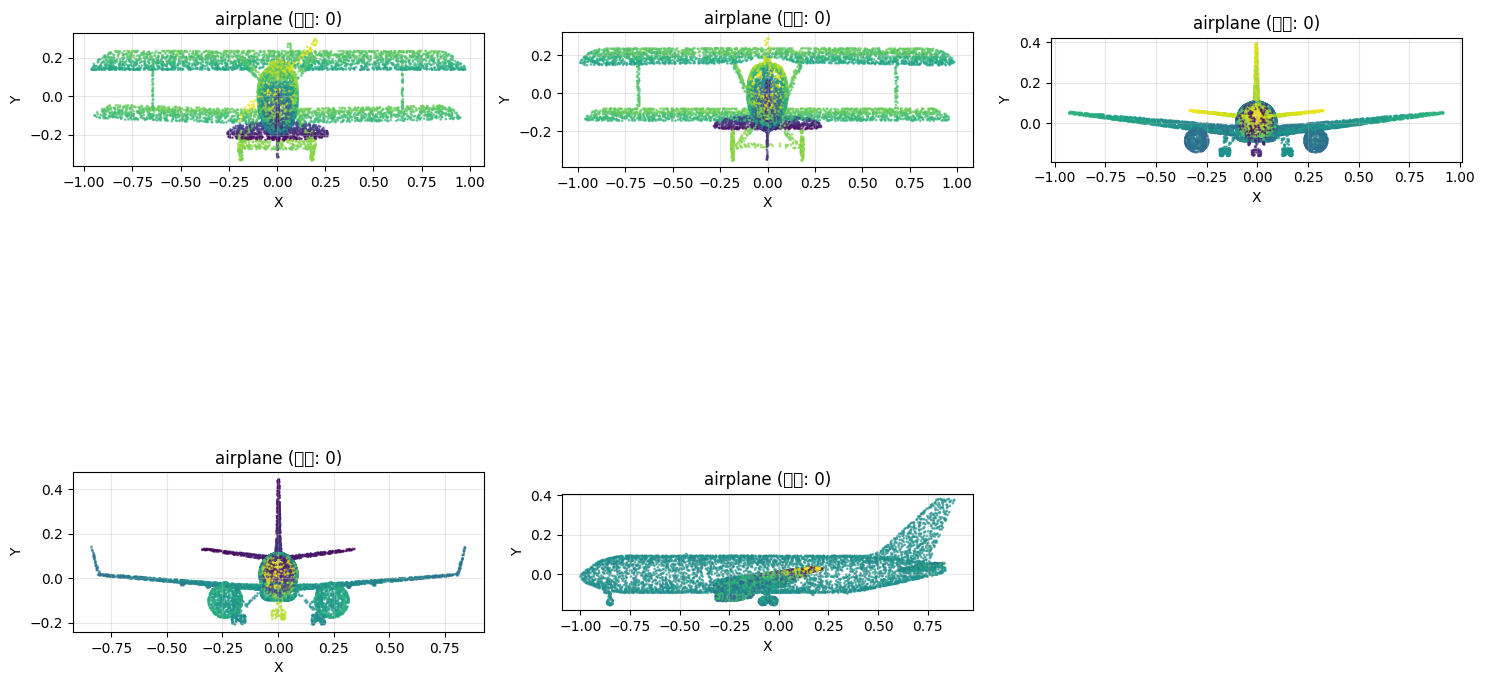

In [55]:
# 使用Matplotlib进行2D投影可视化
def visualize_point_cloud_2d(points, title="2D Projection", ax=None):
    """
    使用Matplotlib可视化3D点云的2D投影
    Args:
        points: 点云数据 (N, 3)
        title: 图表标题
        ax: matplotlib轴对象
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # XY平面投影
    ax.scatter(points[:, 0], points[:, 1], c=points[:, 2], 
               cmap='viridis', s=1, alpha=0.6)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    return ax

# 创建多个子图展示不同类别的样本
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

print("生成2D投影可视化...")

for i, idx in enumerate(sample_indices[:6]):  # 显示前6个样本
    sample = dataset['train'][idx]
    points = np.array(sample['inputs'])
    class_name = label_to_class[sample['label']]
    
    visualize_point_cloud_2d(
        points,  # 直接使用原始点云数据
        title=f"{class_name} (标签: {sample['label']})",
        ax=axes[i]
    )

# 隐藏多余的子图
for i in range(len(sample_indices), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


## 五、数据预处理与增强


In [56]:
# 数据增强类
class PointCloudAugmentation:
    def __init__(self):
        pass
    
    def random_rotation(self, points, max_angle=30):
        """随机旋转"""
        angle = np.random.uniform(-max_angle, max_angle) * np.pi / 180
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        
        # 绕Z轴旋转
        rotation_matrix = np.array([
            [cos_a, -sin_a, 0],
            [sin_a, cos_a, 0],
            [0, 0, 1]
        ])
        
        return points @ rotation_matrix.T
    
    def random_scaling(self, points, scale_range=(0.8, 1.2)):
        """随机缩放"""
        scale = np.random.uniform(scale_range[0], scale_range[1])
        return points * scale
    
    def random_jitter(self, points, std=0.01):
        """随机抖动"""
        noise = np.random.normal(0, std, points.shape)
        return points + noise
    
    def random_dropout(self, points, dropout_ratio=0.1):
        """随机丢弃点"""
        n_points = len(points)
        n_drop = int(n_points * dropout_ratio)
        
        if n_drop > 0:
            drop_indices = np.random.choice(n_points, n_drop, replace=False)
            points = np.delete(points, drop_indices, axis=0)
            
            # 如果点数不足，重复采样
            if len(points) < 1024:
                indices = np.random.choice(len(points), 1024, replace=True)
                points = points[indices]
        
        return points
    
    def augment(self, points, training=True):
        """数据增强主函数"""
        if not training:
            return points
        
        # 随机旋转
        points = self.random_rotation(points)
        
        # 随机缩放
        points = self.random_scaling(points)
        
        # 随机抖动
        points = self.random_jitter(points)
        
        # 随机丢弃（概率性）
        if np.random.random() < 0.3:
            points = self.random_dropout(points)
        
        return points

# 创建数据增强器
augmenter = PointCloudAugmentation()

# 测试数据增强
vprint("=== 数据增强测试 ===")
# 使用原始数据集的第一个样本进行测试
sample = dataset['train'][0]
original_points = np.array(sample['inputs'])
augmented_points = augmenter.augment(original_points.copy(), training=True)

vprint(f"原始点云范围: [{original_points.min():.3f}, {original_points.max():.3f}]")
vprint(f"增强后范围: [{augmented_points.min():.3f}, {augmented_points.max():.3f}]")
vprint(f"形状变化: {original_points.shape} -> {augmented_points.shape}")


🔄 未找到预处理数据，开始预处理...
🚀 开始离线预处理ModelNet40数据集

🔄 开始预处理 train 集...
样本数量: 9843
目标点数: 1024


预处理 train: 100%|██████████| 9843/9843 [36:02<00:00,  4.55it/s] 


✅ train 集预处理完成!
  处理时间: 2167.33秒
  平均每样本: 220.19毫秒
  输出文件: ./preprocessed_data/train_processed.npz
  数据形状: (9843, 1024, 3)

🔄 开始预处理 test 集...
样本数量: 2468
目标点数: 1024


预处理 test: 100%|██████████| 2468/2468 [09:29<00:00,  4.33it/s]


✅ test 集预处理完成!
  处理时间: 571.26秒
  平均每样本: 231.47毫秒
  输出文件: ./preprocessed_data/test_processed.npz
  数据形状: (2468, 1024, 3)

🎉 预处理完成!
📁 输出目录: ./preprocessed_data
📄 训练集: ./preprocessed_data/train_processed.npz
📄 测试集: ./preprocessed_data/test_processed.npz

=== FPS预处理效果展示 ===
原始点云形状: (8192, 3)
FPS预处理后形状: (1024, 3)
数据范围: [-0.972, 0.952]


/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/2289143859.py:218: UserWarning:

Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/2289143859.py:218: UserWarning:

Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/2289143859.py:218: UserWarning:

Glyph 37319 (\N{CJK UNIFIED IDEOGRAPH-91C7}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/2289143859.py:218: UserWarning:

Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/2289143859.py:218: UserWarning:

Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/2289143859.py:218: UserWarning:

Glyph 19968 (\N{CJ

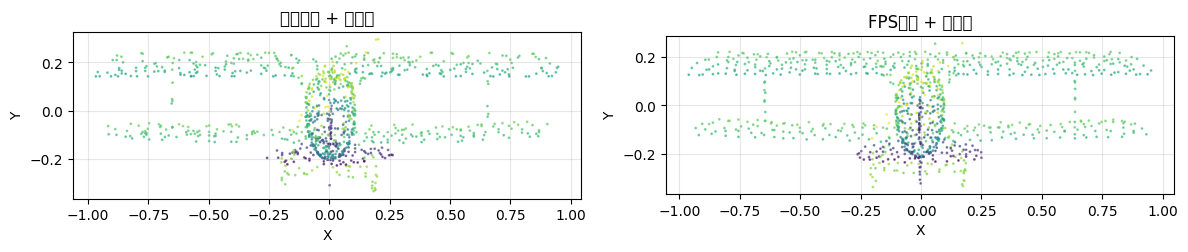


💡 说明:
- FPS采样确保点云在空间中均匀分布
- 预处理在训练前一次性完成，避免训练时重复计算
- 预处理后的数据保存在 .npz 文件中供训练使用
- 如果预处理数据已存在且完整，将直接使用，节省时间


In [57]:
# FPS预处理与数据缓存 - 完整的自包含流程
import os
import time
from tqdm import tqdm

def farthest_point_sampling(points, num_points):
    """
    最远点采样 - 保证采样点在空间中均匀分布
    
    核心思想：贪心地选择离已选点集最远的点，确保空间覆盖均匀
    
    Args:
        points: (N, 3) 原始点云
        num_points: 目标点数
    Returns:
        采样后的点云 (num_points, 3)
    """
    N = points.shape[0]
    
    if N <= num_points:
        # 点数不足，需要重复采样
        shortage = num_points - N
        indices = np.arange(N)
        extra_indices = np.random.choice(N, shortage, replace=True)
        indices = np.concatenate([indices, extra_indices])
        return points[indices]
    
    # 初始化
    centroids = np.zeros(num_points, dtype=np.int32)
    distance = np.ones(N) * 1e10
    farthest = np.random.randint(0, N)  # 随机选择第一个点
    
    for i in range(num_points):
        centroids[i] = farthest
        centroid = points[farthest, :]
        
        # 计算所有点到当前点的距离
        dist = np.sum((points - centroid) ** 2, axis=1)
        
        # 更新每个点到已选点集的最小距离
        distance = np.minimum(distance, dist)
        
        # 选择距离最远的点
        farthest = np.argmax(distance)
    
    return points[centroids]

def preprocess_point_cloud(points, target_points=1024):
    """
    完整的点云预处理流程（包含FPS）
    
    Args:
        points: (N, 3) 原始点云
        target_points: 目标点数
    Returns:
        处理后的点云 (target_points, 3)
    """
    # 1. 移除无效点
    valid_mask = np.isfinite(points).all(axis=1)
    points = points[valid_mask]
    
    # 2. FPS采样到固定点数
    points = farthest_point_sampling(points, target_points)
    
    # 3. 归一化到单位球
    # 中心化
    centroid = np.mean(points, axis=0)
    points = points - centroid
    
    # 单位球归一化
    max_dist = np.max(np.linalg.norm(points, axis=1))
    if max_dist > 0:
        points = points / max_dist
    
    return points.astype(np.float32)

def preprocess_dataset_split(dataset_split, split_name, output_dir, target_points=1024):
    """
    预处理数据集的一个分割（训练集或测试集）
    """
    print(f"\n🔄 开始预处理 {split_name} 集...")
    print(f"样本数量: {len(dataset_split)}")
    print(f"目标点数: {target_points}")
    
    # 存储预处理后的数据
    processed_points = []
    processed_labels = []
    
    start_time = time.time()
    
    for i, sample in enumerate(tqdm(dataset_split, desc=f"预处理 {split_name}")):
        # 获取原始数据
        points = np.array(sample['inputs'])
        label = sample['label']
        
        # 预处理点云
        processed_point = preprocess_point_cloud(points, target_points)
        
        # 存储
        processed_points.append(processed_point)
        processed_labels.append(label)
    
    # 保存预处理后的数据
    output_file = os.path.join(output_dir, f"{split_name}_processed.npz")
    os.makedirs(output_dir, exist_ok=True)
    
    np.savez_compressed(
        output_file,
        points=np.array(processed_points, dtype=np.float32),
        labels=np.array(processed_labels, dtype=np.int64)
    )
    
    end_time = time.time()
    processing_time = end_time - start_time
    
    print(f"✅ {split_name} 集预处理完成!")
    print(f"  处理时间: {processing_time:.2f}秒")
    print(f"  平均每样本: {processing_time/len(dataset_split)*1000:.2f}毫秒")
    print(f"  输出文件: {output_file}")
    print(f"  数据形状: {np.array(processed_points).shape}")
    
    return output_file

# 检查是否已有预处理数据
output_dir = "./preprocessed_data"
train_file = os.path.join(output_dir, "train_processed.npz")
test_file = os.path.join(output_dir, "test_processed.npz")

if os.path.exists(train_file) and os.path.exists(test_file):
    print("✅ 发现已存在的预处理数据，直接使用")
    print(f"训练集文件: {train_file}")
    print(f"测试集文件: {test_file}")
    
    # 验证数据完整性
    train_data = np.load(train_file)
    test_data = np.load(test_file)
    print(f"训练集形状: {train_data['points'].shape}")
    print(f"测试集形状: {test_data['points'].shape}")
    
    if train_data['points'].shape[0] != len(dataset['train']) or test_data['points'].shape[0] != len(dataset['test']):
        print("⚠️ 预处理数据不完整，将重新预处理...")
        need_preprocess = True
    else:
        print("✅ 预处理数据完整，跳过预处理步骤")
        need_preprocess = False
else:
    print("🔄 未找到预处理数据，开始预处理...")
    need_preprocess = True

# 执行预处理（如果需要）
if need_preprocess:
    print("🚀 开始离线预处理ModelNet40数据集")
    print("=" * 50)
    
    # 预处理训练集
    train_file = preprocess_dataset_split(
        dataset['train'], 
        'train', 
        output_dir, 
        target_points=1024
    )
    
    # 预处理测试集
    test_file = preprocess_dataset_split(
        dataset['test'], 
        'test', 
        output_dir, 
        target_points=1024
    )
    
    print(f"\n🎉 预处理完成!")
    print(f"📁 输出目录: {output_dir}")
    print(f"📄 训练集: {train_file}")
    print(f"📄 测试集: {test_file}")

# 测试FPS预处理效果（使用第一个样本）
print("\n=== FPS预处理效果展示 ===")
sample = dataset['train'][0]
original_points = np.array(sample['inputs'])
print(f"原始点云形状: {original_points.shape}")

processed_points = preprocess_point_cloud(original_points, target_points=1024)
print(f"FPS预处理后形状: {processed_points.shape}")
print(f"数据范围: [{processed_points.min():.3f}, {processed_points.max():.3f}]")

# 可视化FPS预处理效果
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 原始点云（随机采样1024个点用于对比）
random_indices = np.random.choice(len(original_points), min(1024, len(original_points)), replace=False)
random_points = original_points[random_indices]

# 归一化随机采样的点云
random_centroid = np.mean(random_points, axis=0)
random_points = random_points - random_centroid
random_max_dist = np.max(np.linalg.norm(random_points, axis=1))
if random_max_dist > 0:
    random_points = random_points / random_max_dist

# 绘制随机采样
axes[0].scatter(random_points[:, 0], random_points[:, 1], 
                c=random_points[:, 2], cmap='viridis', s=1, alpha=0.6)
axes[0].set_title('随机采样 + 归一化')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# 绘制FPS采样
axes[1].scatter(processed_points[:, 0], processed_points[:, 1], 
                c=processed_points[:, 2], cmap='viridis', s=1, alpha=0.6)
axes[1].set_title('FPS采样 + 归一化')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

print("\n💡 说明:")
print("- FPS采样确保点云在空间中均匀分布")
print("- 预处理在训练前一次性完成，避免训练时重复计算")
print("- 预处理后的数据保存在 .npz 文件中供训练使用")
print("- 如果预处理数据已存在且完整，将直接使用，节省时间")


## 六、PointMLP模型架构


In [58]:
# 导入PyTorch相关库
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# 检查GPU可用性（支持CUDA、MPS和CPU）
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

device = get_device()
print(f"使用设备: {device}")

# 显示设备信息
if device.type == 'cuda':
    print(f"CUDA设备: {torch.cuda.get_device_name(0)}")
    print(f"CUDA内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
elif device.type == 'mps':
    print("使用Apple Silicon GPU (MPS)")
    print("注意: MPS在某些操作上可能不如CUDA稳定")
else:
    print("使用CPU进行计算")

# ==================== 官方PointMLP实现 ====================

class GeometricAffine(nn.Module):
    """
    几何仿射模块 - PointMLP的核心创新
    
    作用：对特征进行通道级的仿射变换，增强几何特征表达能力
    公式：y = alpha * x + beta
    
    参数：
        - alpha: 可学习的缩放参数
        - beta: 可学习的偏移参数
    """
    def __init__(self, channels):
        super(GeometricAffine, self).__init__()
        self.alpha = nn.Parameter(torch.ones(1, channels, 1))
        self.beta = nn.Parameter(torch.zeros(1, channels, 1))
    
    def forward(self, x):
        """
        Args:
            x: (B, C, N) 特征图
        Returns:
            仿射变换后的特征 (B, C, N)
        """
        return self.alpha * x + self.beta


class ResidualMLPBlock(nn.Module):
    """
    残差MLP块 - 包含Geometric Affine和残差连接
    
    结构：
        Pre-activation: BN → ReLU → Linear → GA
        残差连接: out = f(x) + x
    """
    def __init__(self, in_channels, out_channels=None, pre_act=True):
        super(ResidualMLPBlock, self).__init__()
        if out_channels is None:
            out_channels = in_channels
        
        self.pre_act = pre_act
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # Pre-activation（BN → ReLU → Linear）
        if pre_act:
            self.bn1 = nn.BatchNorm1d(in_channels)
            self.relu1 = nn.ReLU(inplace=True)
        
        self.linear1 = nn.Linear(in_channels, out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.ga = GeometricAffine(out_channels)
        
        # 残差连接的投影层（如果维度不同）
        if in_channels != out_channels:
            self.shortcut = nn.Linear(in_channels, out_channels)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        """
        Args:
            x: (B, N, C) 输入特征
        Returns:
            out: (B, N, C) 输出特征
        """
        identity = x
        
        # Pre-activation
        if self.pre_act:
            # 转置为 (B, C, N) 进行BatchNorm
            x_t = x.transpose(1, 2)
            out = self.bn1(x_t)
            out = out.transpose(1, 2)  # 转回 (B, N, C)
            out = self.relu1(out)
        else:
            out = x
        
        # MLP
        out = self.linear1(out)  # (B, N, out_C)
        
        # BatchNorm + Geometric Affine
        out_t = out.transpose(1, 2)  # (B, out_C, N)
        out_t = self.bn2(out_t)
        out_t = self.ga(out_t)
        out = out_t.transpose(1, 2)  # (B, N, out_C)
        
        # 残差连接
        identity = self.shortcut(identity)
        out = out + identity
        
        return out


class PointMLP(nn.Module):
    """
    官方PointMLP - 高性能纯MLP 3D点云分类网络
    
    论文: "Rethinking Network Design and Local Geometry in Point Cloud"
    链接: https://arxiv.org/abs/2202.07123
    
    核心创新：
    1. Geometric Affine模块：增强几何特征表达
    2. 残差连接：深层特征提取
    3. Pre-activation设计：更好的梯度流
    4. 分阶段特征提取：逐步抽象
    
    性能：ModelNet40准确率 94.5%
    """
    def __init__(self, num_classes=40, num_points=1024, embed_dim=64):
        super(PointMLP, self).__init__()
        self.num_points = num_points
        self.num_classes = num_classes
        
        # Stage 1: 初始特征嵌入
        self.embedding = nn.Sequential(
            nn.Linear(3, embed_dim),
            nn.BatchNorm1d(embed_dim),
            GeometricAffine(embed_dim),
            nn.ReLU(inplace=True)
        )
        
        # Stage 2: 残差特征提取层
        self.stage1 = nn.Sequential(
            ResidualMLPBlock(embed_dim, embed_dim * 2, pre_act=True),
            ResidualMLPBlock(embed_dim * 2, embed_dim * 2, pre_act=True)
        )
        
        self.stage2 = nn.Sequential(
            ResidualMLPBlock(embed_dim * 2, embed_dim * 4, pre_act=True),
            ResidualMLPBlock(embed_dim * 4, embed_dim * 4, pre_act=True)
        )
        
        self.stage3 = nn.Sequential(
            ResidualMLPBlock(embed_dim * 4, embed_dim * 8, pre_act=True),
            ResidualMLPBlock(embed_dim * 8, embed_dim * 8, pre_act=True)
        )
        
        self.stage4 = nn.Sequential(
            ResidualMLPBlock(embed_dim * 8, embed_dim * 16, pre_act=True),
            ResidualMLPBlock(embed_dim * 16, embed_dim * 16, pre_act=True)
        )
        
        # Stage 3: 全局特征聚合（排列不变）
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        
        # Stage 4: 分类头
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 16, embed_dim * 8),
            nn.BatchNorm1d(embed_dim * 8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(embed_dim * 8, embed_dim * 4),
            nn.BatchNorm1d(embed_dim * 4),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(embed_dim * 4, num_classes)
        )
    
    def forward(self, x):
        """
        前向传播
        Args:
            x: (B, N, 3) 输入点云
        Returns:
            output: (B, num_classes) 分类结果
        """
        batch_size = x.size(0)
        
        # 重塑为 (B*N, 3) 进行初始嵌入
        x = x.view(-1, 3)  # (B*N, 3)
        
        # Stage 1: 初始特征嵌入
        # 转置为 (B, C, N) 格式进行BatchNorm
        x = self.embedding[0](x)  # Linear: (B*N, embed_dim)
        x = x.view(batch_size, self.num_points, -1)  # (B, N, embed_dim)
        x_t = x.transpose(1, 2)  # (B, embed_dim, N)
        x_t = self.embedding[1](x_t)  # BatchNorm
        x_t = self.embedding[2](x_t)  # GeometricAffine
        x_t = self.embedding[3](x_t)  # ReLU
        x = x_t.transpose(1, 2)  # (B, N, embed_dim)
        
        # Stage 2: 多阶段残差特征提取
        x = self.stage1(x)  # (B, N, 128)
        x = self.stage2(x)  # (B, N, 256)
        x = self.stage3(x)  # (B, N, 512)
        x = self.stage4(x)  # (B, N, 1024)
        
        # Stage 3: 全局特征聚合
        x = x.transpose(1, 2)  # (B, 1024, N)
        global_features = self.global_pool(x)  # (B, 1024, 1)
        global_features = global_features.squeeze(-1)  # (B, 1024)
        
        # Stage 4: 分类
        output = self.classifier(global_features)
        
        return output

# 创建模型实例
model = PointMLP(num_classes=40, num_points=1024).to(device)

# 计算模型参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=== PointMLP模型信息 ===")
print(f"总参数量: {total_params:,}")
print(f"可训练参数: {trainable_params:,}")
print(f"模型大小: {total_params * 4 / 1024 / 1024:.2f} MB")

# 测试模型前向传播
print("\n=== 模型测试 ===")
test_input = torch.randn(2, 1024, 3).to(device)
with torch.no_grad():
    test_output = model(test_input)
    
    # MPS设备需要同步
    if device.type == 'mps':
        torch.mps.synchronize()
    
    print(f"输入形状: {test_input.shape}")
    print(f"输出形状: {test_output.shape}")
    print(f"输出范围: [{test_output.min():.3f}, {test_output.max():.3f}]")
    
    # 测试不同设备上的性能
    if device.type == 'mps':
        print("✅ MPS设备测试成功！")
    elif device.type == 'cuda':
        print("✅ CUDA设备测试成功！")
    else:
        print("✅ CPU设备测试成功！")


使用设备: mps
使用Apple Silicon GPU (MPS)
注意: MPS在某些操作上可能不如CUDA稳定
=== PointMLP模型信息 ===
总参数量: 3,480,616
可训练参数: 3,480,616
模型大小: 13.28 MB

=== 模型测试 ===
输入形状: torch.Size([2, 1024, 3])
输出形状: torch.Size([2, 40])
输出范围: [-1.320, 1.527]
✅ MPS设备测试成功！


## 七、数据集类与数据加载器


In [59]:
# 自定义数据集类
class ModelNet40Dataset(Dataset):
    def __init__(self, data_file, augmenter=None, training=True):
        self.data_file = data_file
        self.augmenter = augmenter
        self.training = training
        
        # 加载预处理好的数据
        data = np.load(data_file)
        self.points = data['points']  # (N, 1024, 3)
        self.labels = data['labels']  # (N,)
        
        # 延迟转换为tensor
        self.points_tensor = None
        self.labels_tensor = None
    
    def __len__(self):
        return len(self.points)
    
    def __getitem__(self, idx):
        # 延迟转换为tensor
        if self.points_tensor is None:
            self.points_tensor = torch.from_numpy(self.points).float()
            self.labels_tensor = torch.from_numpy(self.labels).long()
        
        points = self.points_tensor[idx]  # (1024, 3)
        label = self.labels_tensor[idx]   # scalar
        
        # 数据增强（如果需要）
        if self.augmenter is not None:
            points_np = points.numpy()
            augmented_points = self.augmenter.augment(points_np, training=self.training)
            points = torch.from_numpy(augmented_points).float()
        
        return points, label

# 创建训练和测试数据集
log("=== 创建数据集 ===")
train_file = "./preprocessed_data/train_processed.npz"
test_file = "./preprocessed_data/test_processed.npz"

train_dataset = ModelNet40Dataset(train_file, augmenter, training=True)
test_dataset = ModelNet40Dataset(test_file, None, training=False)

log(f"训练集大小: {len(train_dataset)}")
log(f"测试集大小: {len(test_dataset)}")

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,  # 设置为0避免多进程问题
    pin_memory=True if device.type == 'cuda' else False  # 只有CUDA支持pin_memory
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0,  # 设置为0避免多进程问题
    pin_memory=True if device.type == 'cuda' else False  # 只有CUDA支持pin_memory
)

log(f"训练批次数: {len(train_loader)}")
log(f"测试批次数: {len(test_loader)}")

# 测试数据加载器
vprint("\n=== 数据加载器测试 ===")
try:
    for batch_idx, (points, labels) in enumerate(train_loader):
        vprint(f"批次 {batch_idx + 1}:")
        vprint(f"  点云形状: {points.shape}")
        vprint(f"  标签形状: {labels.shape}")
        vprint(f"  标签范围: {labels.min().item()} - {labels.max().item()}")
        if batch_idx >= 2:  # 只测试前3个批次
            break
    vprint("✅ 数据加载器测试成功！")
except Exception as e:
    log(f"❌ 数据加载器测试失败: {e}")
    log("尝试使用更小的批次大小...")
    
    # 使用更小的批次大小重试
    small_batch_size = 8
    small_train_loader = DataLoader(
        train_dataset, 
        batch_size=small_batch_size, 
        shuffle=True, 
        num_workers=0,
        pin_memory=False
    )
    
    for batch_idx, (points, labels) in enumerate(small_train_loader):
        vprint(f"小批次 {batch_idx + 1}:")
        vprint(f"  点云形状: {points.shape}")
        vprint(f"  标签形状: {labels.shape}")
        if batch_idx >= 1:  # 只测试前2个批次
            break
    vprint("✅ 小批次数据加载器测试成功！")
    
    # 更新批次大小
    batch_size = small_batch_size
    train_loader = small_train_loader
    test_loader = DataLoader(
        test_dataset, 
        batch_size=small_batch_size, 
        shuffle=False, 
        num_workers=0,
        pin_memory=False
    )


=== 创建数据集 ===
训练集大小: 9843
测试集大小: 2468
训练批次数: 308
测试批次数: 78


## 八、模型训练


In [60]:
# 训练配置
class TrainingConfig:
    def __init__(self):
        self.epochs = 20  # 减少训练轮数以便快速测试
        self.learning_rate = 0.001
        self.weight_decay = 1e-4
        self.scheduler_step = 10  # 调整学习率调度
        self.scheduler_gamma = 0.5
        self.save_interval = 5  # 更频繁保存
        self.log_interval = 100  # 减少打印频率

config = TrainingConfig()

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.scheduler_step, gamma=config.scheduler_gamma)

# 训练历史记录
train_losses = []
train_accuracies = []
test_accuracies = []

print("=== 训练配置 ===")
print(f"训练轮数: {config.epochs}")
print(f"学习率: {config.learning_rate}")
print(f"批次大小: {batch_size}")
print(f"优化器: Adam")
print(f"损失函数: CrossEntropyLoss")
print(f"设备: {device}")
print(f"数据加载器工作进程: 0 (避免多进程问题)")
print(f"Pin Memory: {'启用' if device.type == 'cuda' else '禁用'}")

# 训练函数
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (points, labels) in enumerate(train_loader):
        points, labels = points.to(device), labels.to(device)
        
        # 前向传播
        optimizer.zero_grad()
        outputs = model(points)
        loss = criterion(outputs, labels)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # MPS设备需要同步
        if device.type == 'mps':
            torch.mps.synchronize()
        
        # 统计
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 打印进度
        if batch_idx % config.log_interval == 0:
            print(f'批次 [{batch_idx}/{len(train_loader)}], '
                  f'损失: {loss.item():.4f}, '
                  f'准确率: {100. * correct / total:.2f}%')
    
    # 打印最终统计
    print(f'训练完成 - 平均损失: {total_loss / len(train_loader):.4f}, '
          f'最终准确率: {100. * correct / total:.2f}%')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy

# 测试函数
def test_epoch(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for points, labels in test_loader:
            points, labels = points.to(device), labels.to(device)
            
            outputs = model(points)
            loss = criterion(outputs, labels)
            
            # MPS设备需要同步
            if device.type == 'mps':
                torch.mps.synchronize()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy

print("\n=== 开始训练 ===")
best_accuracy = 0

for epoch in range(config.epochs):
    print(f'\n轮次 {epoch+1}/{config.epochs}')
    print('-' * 50)
    
    # 训练
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    
    # 测试
    test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
    
    # 学习率调度
    scheduler.step()
    
    # 记录历史
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    # 打印结果
    print(f'训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.2f}%')
    print(f'测试损失: {test_loss:.4f}, 测试准确率: {test_acc:.2f}%')
    print(f'当前学习率: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # 保存最佳模型
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        try:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_accuracy': best_accuracy,
            }, 'best_model.pth')
            print(f'✅ 保存最佳模型，准确率: {best_accuracy:.2f}%')
        except Exception as e:
            print(f'❌ 保存模型失败: {e}')
    
    # 定期保存检查点
    if (epoch + 1) % config.save_interval == 0:
        try:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_accuracies': test_accuracies,
            }, f'checkpoint_epoch_{epoch+1}.pth')
            print(f'✅ 保存检查点 epoch_{epoch+1}')
        except Exception as e:
            print(f'❌ 保存检查点失败: {e}')

print(f'\n训练完成！最佳测试准确率: {best_accuracy:.2f}%')


=== 训练配置 ===
训练轮数: 20
学习率: 0.001
批次大小: 32
优化器: Adam
损失函数: CrossEntropyLoss
设备: mps
数据加载器工作进程: 0 (避免多进程问题)
Pin Memory: 禁用

=== 开始训练 ===

轮次 1/20
--------------------------------------------------
批次 [0/308], 损失: 3.6876, 准确率: 9.38%
批次 [100/308], 损失: 1.9373, 准确率: 38.55%
批次 [200/308], 损失: 1.1496, 准确率: 45.66%
批次 [300/308], 损失: 1.1556, 准确率: 50.06%
训练完成 - 平均损失: 1.8849, 最终准确率: 50.47%
训练损失: 1.8849, 训练准确率: 50.47%
测试损失: 1.3459, 测试准确率: 57.13%
当前学习率: 0.001000
✅ 保存最佳模型，准确率: 57.13%

轮次 2/20
--------------------------------------------------
批次 [0/308], 损失: 1.3298, 准确率: 53.12%
批次 [100/308], 损失: 0.9242, 准确率: 61.51%
批次 [200/308], 损失: 1.2569, 准确率: 63.23%
批次 [300/308], 损失: 1.0764, 准确率: 64.42%
训练完成 - 平均损失: 1.2210, 最终准确率: 64.51%
训练损失: 1.2210, 训练准确率: 64.51%
测试损失: 1.2537, 测试准确率: 63.09%
当前学习率: 0.001000
✅ 保存最佳模型，准确率: 63.09%

轮次 3/20
--------------------------------------------------
批次 [0/308], 损失: 1.1681, 准确率: 65.62%
批次 [100/308], 损失: 0.9234, 准确率: 67.76%
批次 [200/308], 损失: 0.8318, 准确率: 68.07%
批次 [300/308], 损失: 

## 九、模型评估与可视化


In [61]:
# 加载最佳模型
print("=== 加载最佳模型 ===")
try:
    checkpoint = torch.load('best_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_accuracy = checkpoint['best_accuracy']
    print(f"✅ 成功加载最佳模型，准确率: {best_accuracy:.2f}%")
except FileNotFoundError:
    print("❌ 未找到最佳模型文件，使用当前模型进行评估")
    best_accuracy = test_accuracies[-1] if test_accuracies else 0.0
except Exception as e:
    print(f"❌ 加载模型失败: {e}")
    print("使用当前模型进行评估")
    best_accuracy = test_accuracies[-1] if test_accuracies else 0.0

# 详细评估函数
def detailed_evaluation(model, test_loader, device, class_names):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for points, labels in test_loader:
            points, labels = points.to(device), labels.to(device)
            
            outputs = model(points)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            # MPS设备需要同步
            if device.type == 'mps':
                torch.mps.synchronize()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)

# 执行详细评估
vprint("\n=== 详细评估 ===")
predictions, true_labels, probabilities = detailed_evaluation(
    model, test_loader, device, modelnet40_classes
)

# 计算整体准确率
overall_accuracy = np.mean(predictions == true_labels)
log(f"整体准确率: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

# 计算每个类别的准确率
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class_accuracy = []
for i in range(40):
    mask = true_labels == i
    if np.sum(mask) > 0:
        acc = np.mean(predictions[mask] == true_labels[mask])
        class_accuracy.append(acc)
    else:
        class_accuracy.append(0.0)

vprint(f"\n各类别准确率:")
for i, acc in enumerate(class_accuracy):
    vprint(f"{i:2d}. {modelnet40_classes[i]:15s}: {acc:.4f} ({acc*100:.2f}%)")

# 找出表现最好和最差的类别
best_classes = np.argsort(class_accuracy)[-5:]
worst_classes = np.argsort(class_accuracy)[:5]

vprint(f"\n表现最好的5个类别:")
for i in best_classes:
    vprint(f"  {modelnet40_classes[i]:15s}: {class_accuracy[i]:.4f}")

vprint(f"\n表现最差的5个类别:")
for i in worst_classes:
    vprint(f"  {modelnet40_classes[i]:15s}: {class_accuracy[i]:.4f}")


=== 加载最佳模型 ===
✅ 成功加载最佳模型，准确率: 84.32%
整体准确率: 0.8432 (84.32%)


/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/326486500.py:31: UserWarning:

Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/326486500.py:31: UserWarning:

Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/326486500.py:31: UserWarning:

Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/326486500.py:31: UserWarning:

Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/326486500.py:31: UserWarning:

Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/326486500.py:31: UserWarning:

Glyph 32451 (\N{CJK UNIFIED ID

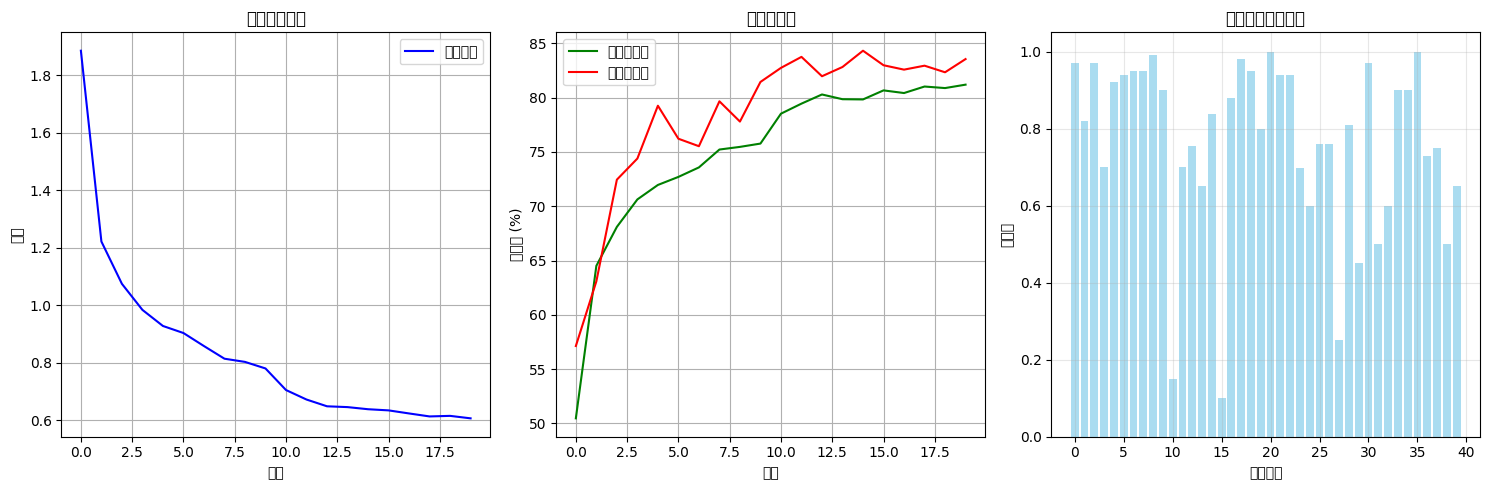


=== 混淆矩阵 (前20个类别) ===


/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/326486500.py:48: UserWarning:

Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/326486500.py:48: UserWarning:

Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/326486500.py:48: UserWarning:

Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/326486500.py:48: UserWarning:

Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/326486500.py:48: UserWarning:

Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/326486500.py:48: UserWarning:

Glyph 23454 (\N{CJK UNIFIED ID

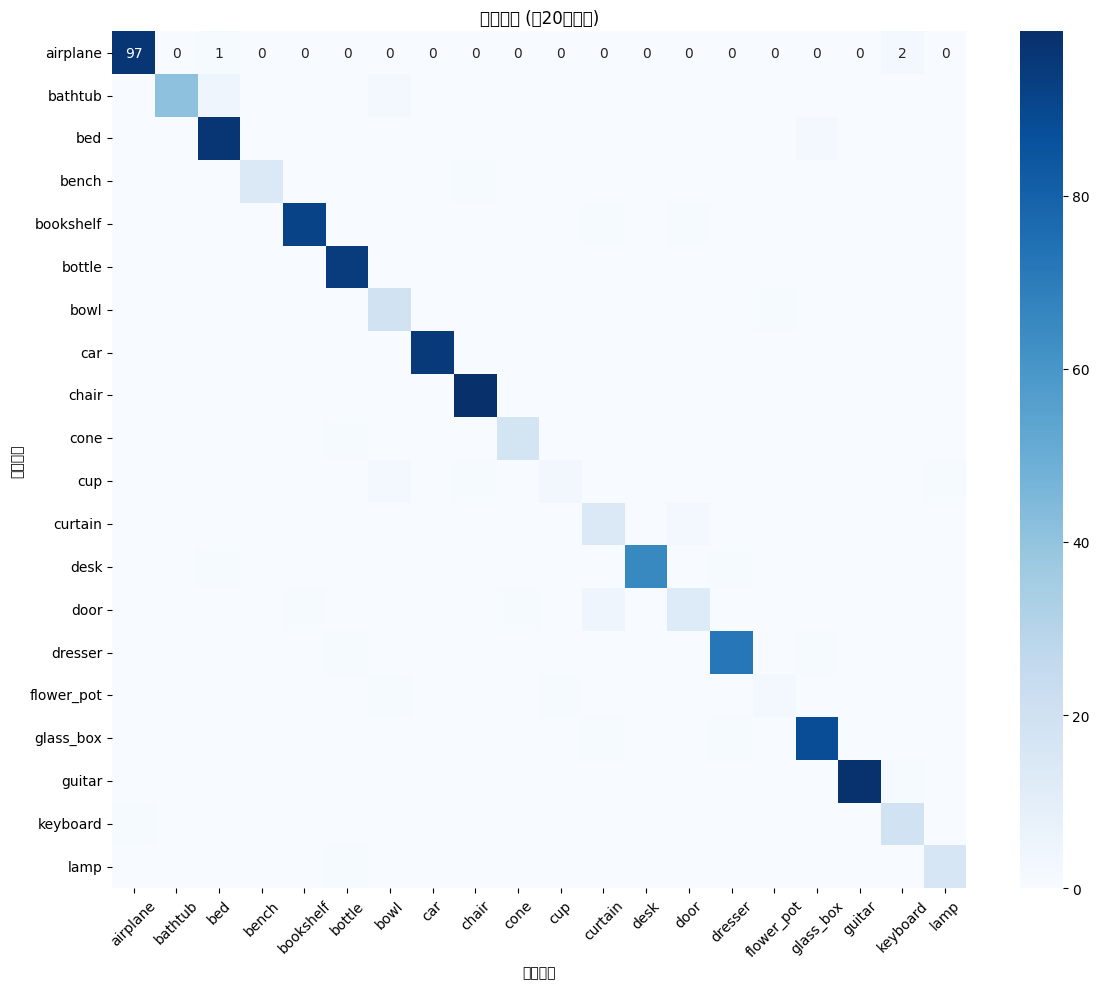


=== 分类报告 ===
前10个类别的详细报告:
airplane       : P=0.990, R=0.970, F1=0.980, S=100
bathtub        : P=0.976, R=0.820, F1=0.891, S=50
bed            : P=0.866, R=0.970, F1=0.915, S=100
bench          : P=0.609, R=0.700, F1=0.651, S=20
bookshelf      : P=0.836, R=0.920, F1=0.876, S=100
bottle         : P=0.870, R=0.940, F1=0.904, S=100
bowl           : P=0.613, R=0.950, F1=0.745, S=20
car            : P=0.969, R=0.950, F1=0.960, S=100
chair          : P=0.961, R=0.990, F1=0.975, S=100
cone           : P=0.857, R=0.900, F1=0.878, S=20

整体指标:
宏平均精确率: 0.7787
宏平均召回率: 0.7655
宏平均F1分数: 0.7598
加权平均精确率: 0.8442
加权平均召回率: 0.8432
加权平均F1分数: 0.8385


In [62]:
# 训练过程可视化
plt.figure(figsize=(15, 5))

# 损失曲线
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='训练损失', color='blue')
plt.title('训练损失曲线')
plt.xlabel('轮次')
plt.ylabel('损失')
plt.legend()
plt.grid(True)

# 准确率曲线
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='训练准确率', color='green')
plt.plot(test_accuracies, label='测试准确率', color='red')
plt.title('准确率曲线')
plt.xlabel('轮次')
plt.ylabel('准确率 (%)')
plt.legend()
plt.grid(True)

# 类别准确率分布
plt.subplot(1, 3, 3)
plt.bar(range(40), class_accuracy, color='skyblue', alpha=0.7)
plt.title('各类别准确率分布')
plt.xlabel('类别索引')
plt.ylabel('准确率')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 混淆矩阵（只显示前20个类别，避免过于密集）
print("\n=== 混淆矩阵 (前20个类别) ===")
cm = confusion_matrix(true_labels, predictions)
cm_subset = cm[:20, :20]  # 只显示前20x20

plt.figure(figsize=(12, 10))
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', 
            xticklabels=modelnet40_classes[:20], 
            yticklabels=modelnet40_classes[:20])
plt.title('混淆矩阵 (前20个类别)')
plt.xlabel('预测类别')
plt.ylabel('真实类别')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 分类报告
print("\n=== 分类报告 ===")
report = classification_report(true_labels, predictions, 
                              target_names=modelnet40_classes, 
                              output_dict=True)

# 显示前10个类别的详细报告
print("前10个类别的详细报告:")
for i in range(10):
    class_name = modelnet40_classes[i]
    if class_name in report:
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']
        print(f"{class_name:15s}: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}, S={support}")

# 整体指标
print(f"\n整体指标:")
print(f"宏平均精确率: {report['macro avg']['precision']:.4f}")
print(f"宏平均召回率: {report['macro avg']['recall']:.4f}")
print(f"宏平均F1分数: {report['macro avg']['f1-score']:.4f}")
print(f"加权平均精确率: {report['weighted avg']['precision']:.4f}")
print(f"加权平均召回率: {report['weighted avg']['recall']:.4f}")
print(f"加权平均F1分数: {report['weighted avg']['f1-score']:.4f}")


=== 预测示例 ===


/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/2315648444.py:57: UserWarning:

Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/2315648444.py:57: UserWarning:

Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/2315648444.py:57: UserWarning:

Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/2315648444.py:57: UserWarning:

Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/2315648444.py:57: UserWarning:

Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.

/var/folders/y_/g595hp191h75fwdk_s4cf6bm0000gn/T/ipykernel_5237/2315648444.py:57: UserWarning:

Glyph 27979 (\N{CJK UNIF

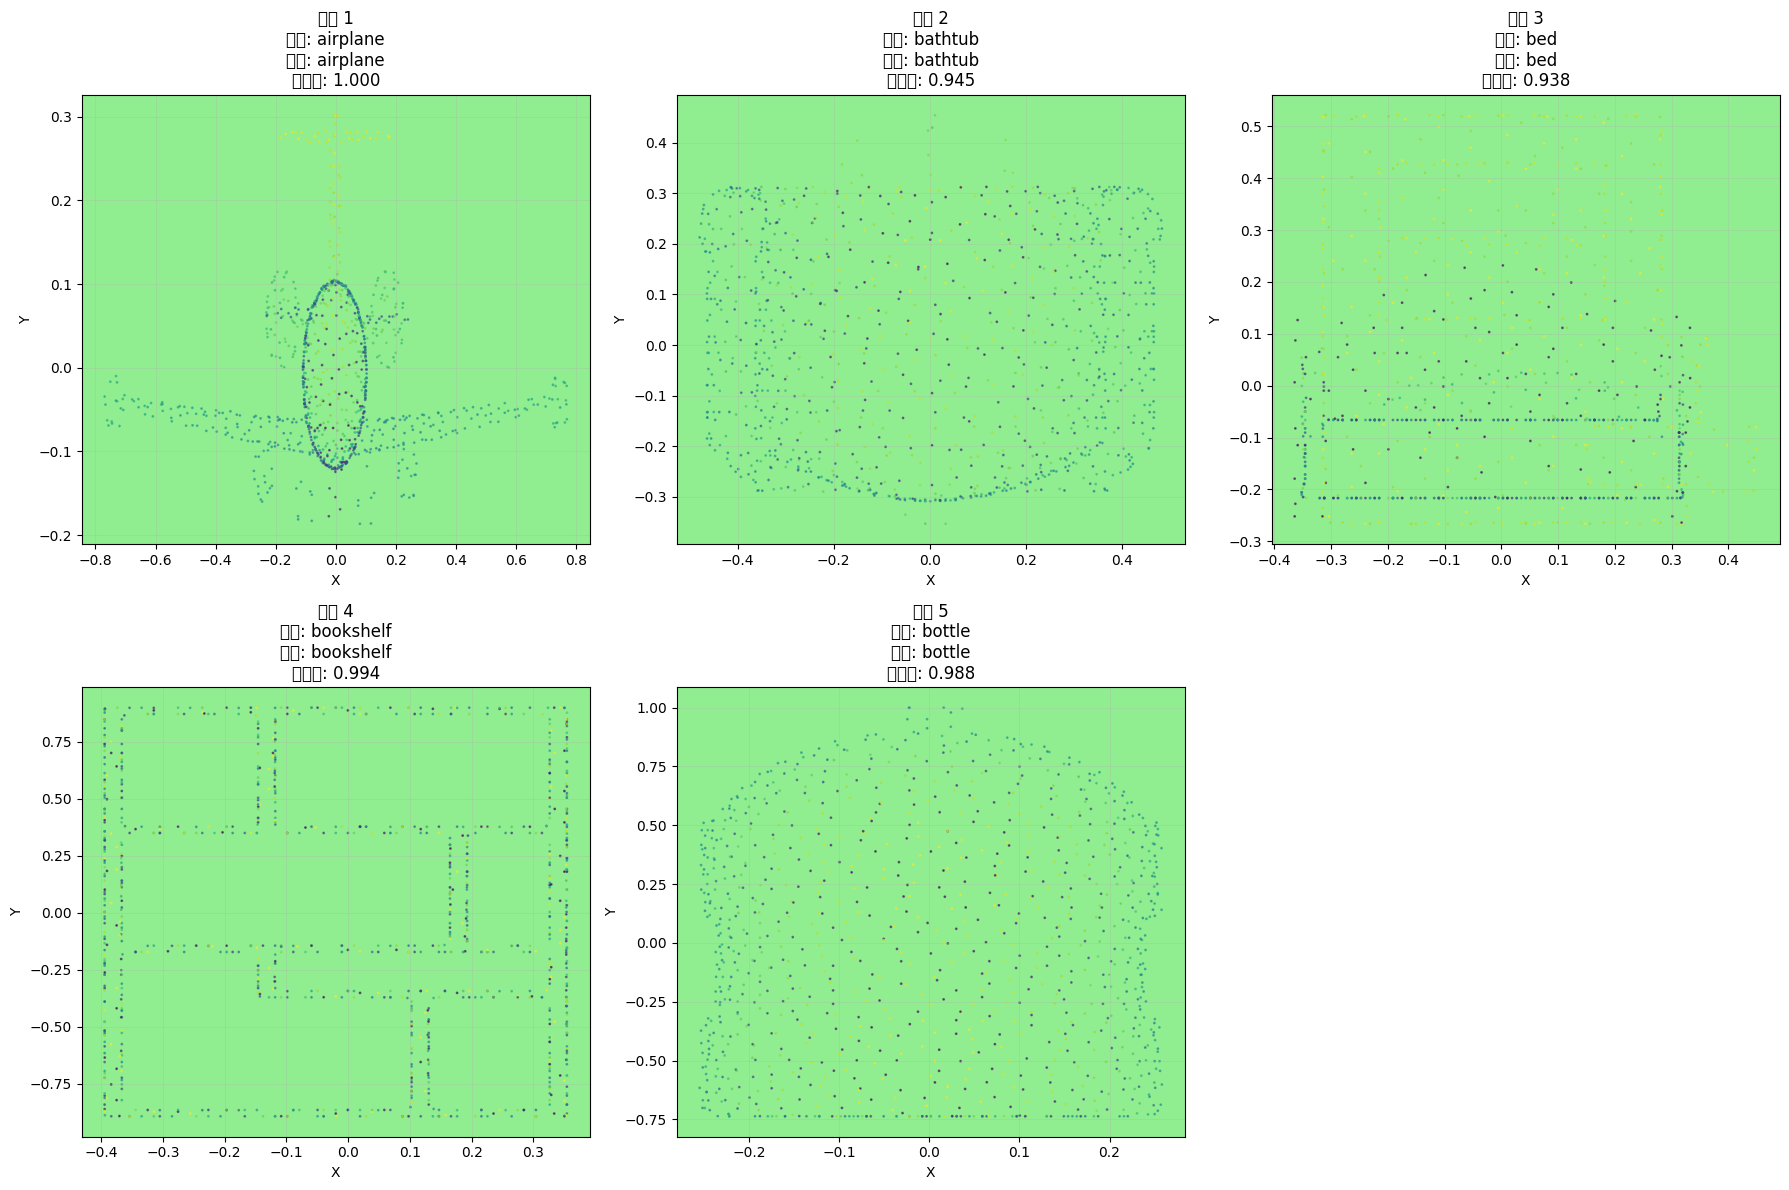


预测结果详情:
样本 1: ✓ 真实=airplane, 预测=airplane, 置信度=1.000
样本 2: ✓ 真实=bathtub, 预测=bathtub, 置信度=0.945
样本 3: ✓ 真实=bed, 预测=bed, 置信度=0.938
样本 4: ✓ 真实=bookshelf, 预测=bookshelf, 置信度=0.994
样本 5: ✓ 真实=bottle, 预测=bottle, 置信度=0.988

=== 模型性能总结 ===
最佳测试准确率: 84.32%
整体测试准确率: 84.32%
模型参数量: 3,480,616
模型大小: 13.28 MB
训练轮数: 20
批次大小: 32

✅ 结果已保存到 training_results.json


In [63]:
# 预测示例和可视化
def predict_sample(model, test_dataset, sample_idx, device, class_names):
    """预测单个样本"""
    model.eval()
    
    # 直接从预处理好的数据集获取数据
    points, true_label = test_dataset[sample_idx]
    points_tensor = points.unsqueeze(0).to(device)
    
    # 预测
    with torch.no_grad():
        outputs = model(points_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
        
        # MPS设备需要同步
        if device.type == 'mps':
            torch.mps.synchronize()
    
    return predicted_class, confidence, points.numpy(), true_label

# 选择几个测试样本进行预测
print("=== 预测示例 ===")
test_samples = [0, 100, 200, 300, 400]  # 选择5个测试样本

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, sample_idx in enumerate(test_samples):
    # 预测
    pred_class, confidence, processed_points, true_label = predict_sample(
        model, test_dataset, sample_idx, device, modelnet40_classes
    )
    true_class = modelnet40_classes[true_label]
    pred_class_name = modelnet40_classes[pred_class]
    
    # 可视化点云（2D投影）
    ax = axes[i]
    scatter = ax.scatter(processed_points[:, 0], processed_points[:, 1], 
                        c=processed_points[:, 2], cmap='viridis', s=1, alpha=0.6)
    ax.set_title(f'样本 {i+1}\n真实: {true_class}\n预测: {pred_class_name}\n置信度: {confidence:.3f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True, alpha=0.3)
    
    # 设置颜色
    if pred_class == true_label:
        ax.set_facecolor('lightgreen')
    else:
        ax.set_facecolor('lightcoral')

# 隐藏多余的子图
for i in range(len(test_samples), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# 显示预测结果
print("\n预测结果详情:")
for i, sample_idx in enumerate(test_samples):
    pred_class, confidence, _, true_label = predict_sample(
        model, test_dataset, sample_idx, device, modelnet40_classes
    )
    true_class = modelnet40_classes[true_label]
    pred_class_name = modelnet40_classes[pred_class]
    
    status = "✓" if pred_class == true_label else "✗"
    print(f"样本 {i+1}: {status} 真实={true_class}, 预测={pred_class_name}, 置信度={confidence:.3f}")

# 模型性能总结
print(f"\n=== 模型性能总结 ===")
print(f"最佳测试准确率: {best_accuracy:.2f}%")
print(f"整体测试准确率: {overall_accuracy*100:.2f}%")
print(f"模型参数量: {total_params:,}")
print(f"模型大小: {total_params * 4 / 1024 / 1024:.2f} MB")
print(f"训练轮数: {config.epochs}")
print(f"批次大小: {batch_size}")

# 保存最终结果
try:
    results = {
        'best_accuracy': best_accuracy,
        'overall_accuracy': overall_accuracy,
        'class_accuracy': class_accuracy,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'model_params': total_params,
        'config': config.__dict__
    }

    import json
    with open('training_results.json', 'w') as f:
        # 转换numpy数组为列表以便JSON序列化
        results_serializable = {}
        for key, value in results.items():
            if isinstance(value, np.ndarray):
                results_serializable[key] = value.tolist()
            else:
                results_serializable[key] = value
        json.dump(results_serializable, f, indent=2)

    print(f"\n✅ 结果已保存到 training_results.json")
except Exception as e:
    print(f"\n❌ 保存结果失败: {e}")
    print("结果仍在内存中，可以手动保存")
